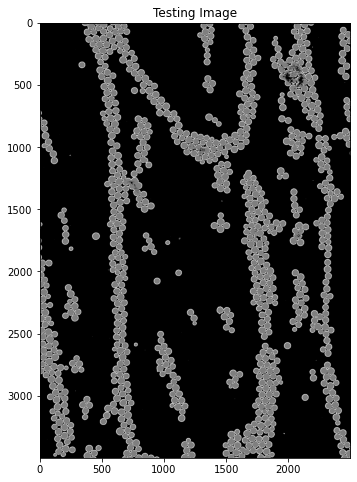

In [7]:
#from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure, color, io

img = cv2.imread('./full-size/tem_predict/segmented_ASM306_grayscale_0008.tif')
img=img[0:3500, 900:3400]
plt.figure(figsize=(8, 8))
plt.title('Testing Image')
plt.imshow(img, cmap='gray')
plt.show()

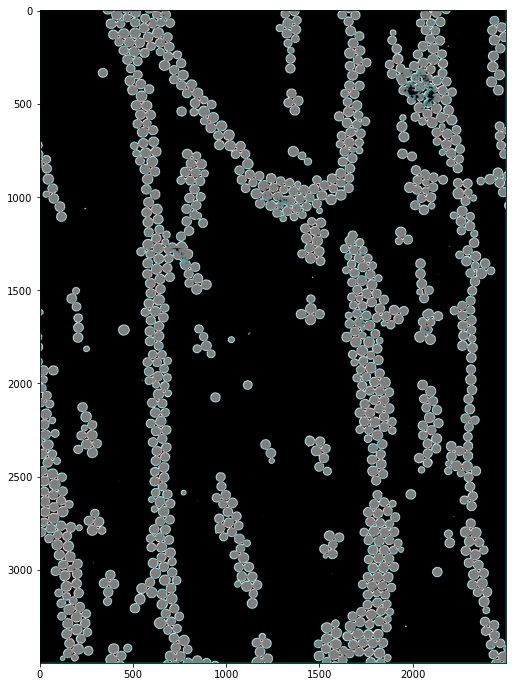

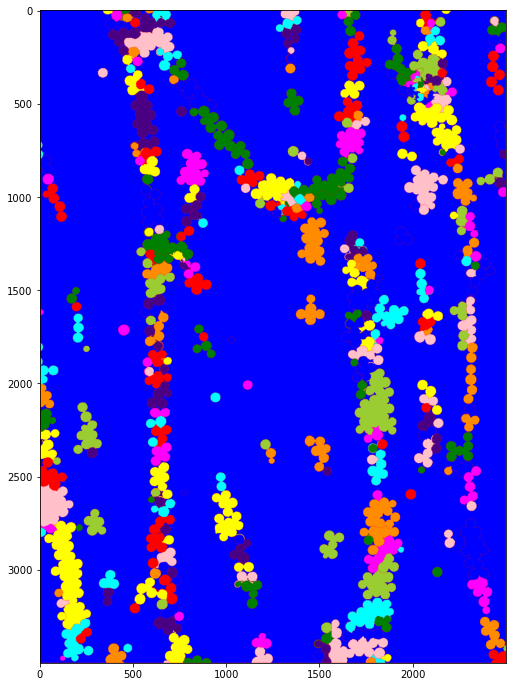

In [13]:
########################################################
#####Watershed

img_grey = img[:,:,0]

## transform the unet result to binary image
#Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
ret1, thresh = cv2.threshold(img_grey, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# Morphological operations to remove small noise - opening
# To remove holes we can use closing
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

from skimage.segmentation import clear_border
opening = clear_border(opening) 

sure_bg = cv2.dilate(opening,kernel,iterations=10)

dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

ret2, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(),255,0)

# Unknown ambiguous region is nothing but bkground - foreground
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# plt.figure(figsize=(12,12))
# plt.imshow(sure_fg)
# plt.show()
# plt.figure(figsize=(12,12))
# plt.imshow(unknown)
# plt.show()

#Now we create a marker and label the regions inside. 

ret3, markers = cv2.connectedComponents(sure_fg)

#One problem rightnow is that the entire background pixels is given value 0.
#This means watershed considers this region as unknown.
#So let us add 10 to all labels so that sure background is not 0, but 10
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
#plt.imshow(markers, cmap='gray')   #Look at the 3 distinct regions.

#Now we are ready for watershed filling. 
markers = cv2.watershed(img, markers)

#Let us color boundaries in yellow. 
img[markers == -1] = [0,255,255]  

img2 = color.label2rgb(markers, bg_label=0)
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()
plt.figure(figsize=(12,12))
plt.imshow(img2)
plt.show()

# #Now, time to extract properties of detected cells
# # regionprops function in skimage measure module calculates useful parameters for each object.


# props = measure.regionprops_table(markers, intensity_image=img_grey, 
#                               properties=['label',
#                                           'area', 'equivalent_diameter',
#                                           'mean_intensity', 'solidity'])
    
# import pandas as pd
# df = pd.DataFrame(props)
# df = df[df.mean_intensity > 100]  #Remove background or other regions that may be counted as objects

# print(df.head())

